In [1]:
from typing import TypeAlias
import math

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
np.random.seed(0)

In [3]:
Sample: TypeAlias = list[int | float]
Data: TypeAlias = list[Sample]

Target: TypeAlias = int | float
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [4]:
# Activation functions

from abc import ABC, abstractmethod


class ActivationBase(ABC):
    @abstractmethod
    def calc(self, x: Sample) -> list[float]:
        """Apply the activation function to an layer output"""
        pass

    @abstractmethod
    def derivative(self, x: Sample):
        pass

#######################################


class ReLU(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return np.maximum(0, x)

    def derivative(self, x: Sample):
        return self.calc(x=x)


class Sigmoid(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        x = np.clip(x, -500, 500)
    
        return np.where(
            x >= 0,
            1 / (1 + np.exp(-x)),
            np.exp(x) / (1 + np.exp(x))
        )

    def derivative(self, x: Sample):
        return self.calc(x) * (1 - self.calc(x))


class Empty(ActivationBase):
    def calc(self, x: Sample):
        return x
    def derivative(self, x: Sample):
        return x

In [492]:
# Loss functions

class LossBase(ABC):
    @abstractmethod
    def calc(self, x: Sample, y: Target) -> float:
        """Apply the loss function to an output layer"""
        pass


class MSELoss(LossBase):
    """For regression""" 
    def calc(self, x: Sample, y: Target) -> float:
        loss = np.clip(0.5 * np.sum((x - y) ** 2), -0.1, 0.1)

        return np.mean(loss)


In [6]:
class Dataset:
    def __init__(self, data: Data, targets: Targets) -> None:
        self.data: Data = data
        self._len = len(data)
        self.targets: Targets = targets

    def __len__(self) -> int:
        return self._len

    def __getitem__(self, index) -> Sample:
        return self.data[index]

    def __iter__(self):
        return iter(self.data)


In [491]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation: ActivationBase = None) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

        self.weights = self._init_weights()
        self.bias = self._init_bias()
        self.output = []

        self.activation = activation

    def _init_weights(self) -> list[float]:
        weights = np.random.randn(self.n_inputs, self.n_neurons) * np.sqrt(2. / self.n_inputs)
        return weights

    def _init_bias(self) -> list[float]:
        return np.random.randn(1)[0]

    def forward(self, inputs) -> None:
        output = []
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                output.append(self.weights[i][j] * inputs[i])

        output = np.array(output)
        output += self.bias

        self.output = self.activation.calc(output)

    def backward(self, delta: list[float]) -> list[float]:
        new_deltas = []
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                new_delta = np.clip(self.weights[i][j] * delta[j], -0.1, 0.1)
                new_delta *= self.activation.derivative(self.output[i + j])
                new_deltas.append(new_delta)
        new_deltas = np.array(new_deltas)
        return new_deltas

    def update_weights(self, delta, learning_rate) -> None:
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                self.weights[i][j] += np.clip(delta[i + j] * self.output[i + j] * learning_rate, -0.1, 0.1)

Layers: TypeAlias = list[Linear]

In [275]:
class Model:
    def __init__(self, layers: Layers, loss: LossBase):
        self.layers = layers
        self._layers_len = len(layers)
        self.loss = loss

    def fit(self, dataset: Dataset, n_epoch: int = 1, learning_rate: float = 0.01, verbose: bool = True) -> list[float]:
        losses_by_epoch = []

        range_epoch = range(n_epoch)
        if verbose:
            range_epoch = tqdm(range_epoch, desc="epochs", position=0)

        for epoch in range_epoch:
            epoch_losses = []

            for i,sample in enumerate(dataset):
                if not isinstance(sample, list):
                    sample = [sample]

                sample = np.array(sample)

                # Forward pass
                self.layers[0].forward(inputs=sample) # input layer
                for j in range(1, self._layers_len):
                    self.layers[j].forward(inputs=self.layers[j-1].output)

                target = dataset.targets[i]

                # Calc loss
                output_error = self.calc_loss(target=target)
                epoch_losses.append(output_error)

                # Backward pass
                delta_list = []
                delta = np.array([output_error])
                delta_list.append(delta)
                for i in range(self._layers_len - 1, -1, -1):
                    delta = self.layers[i].backward(delta=delta_list[-1])
                    delta_list.append(delta)

                # Update weights
                delta_list = delta_list[::-1]
                for i in range(self._layers_len):
                   self.layers[i].update_weights(delta=delta_list[i], learning_rate=learning_rate)

            mean_loss = np.mean(epoch_losses)
            losses_by_epoch.append(mean_loss)

        return losses_by_epoch

    def predict(self, sample: Sample) -> list[float]:
        sample = np.array([sample])

        self.layers[0].forward(inputs=sample)
        for i in range(1, self._layers_len):
            self.layers[i].forward(inputs=self.layers[i-1].output)

        return np.mean(self.layers[-1].output)

    def calc_loss(self, target: Target) -> float:
        output_layer = self.layers[-1]
        output = output_layer.output

        loss = self.loss.calc(x=output, y=target)
        return loss

    def set_weights(self, weights: Weights) -> None:
        for w,layer in zip(weights, self.layers):
            layer.weights = w

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.layers]
        return weights

## Dataset

In [730]:
X = sorted(np.random.uniform(0, 10, 500))
y = [math.cos(x) for x in X]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

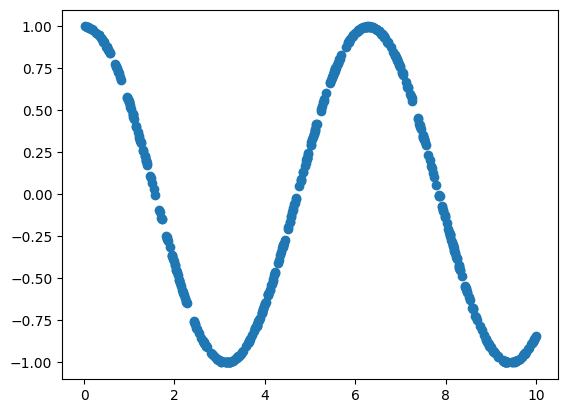

In [ ]:
plt.plot(X, y, 'o')
plt.show()

In [10]:
train_dataset = Dataset(data=X_train, targets=y_train)

layers = [
    Linear(1,1, activation=Sigmoid()),
    Linear(1,1, activation=Empty()),
]

model = Model(layers=layers, loss=MSELoss())


losses = model.fit(dataset=train_dataset, n_epoch=10, learning_rate=0.01, verbose=1)

epochs: 100%|██████████| 10/10 [00:00<00:00, 85.93it/s]


In [965]:
losses

[0.0791304547875099,
 0.07913109396463681,
 0.0791317367974,
 0.07913238328416661,
 0.079133033423301,
 0.0791336872131648,
 0.0791343446521169,
 0.07913500573851344,
 0.07913567047070785,
 0.07913633884705079]

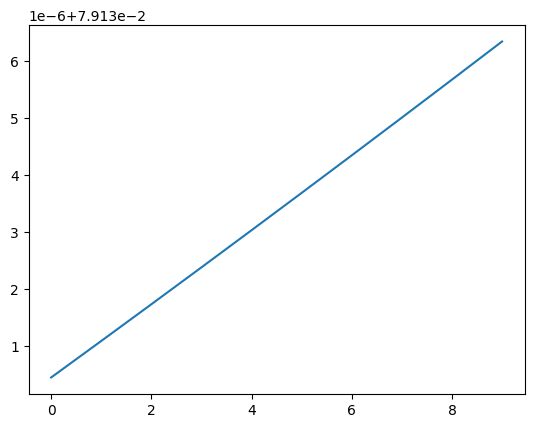

In [964]:
plt.plot(losses)
plt.show()

In [13]:
preds = []
for i in X_val:
    pred = model.predict(i)
    preds.append(pred)

epochs: 100%|██████████| 10/10 [00:00<00:00, 65.53it/s]


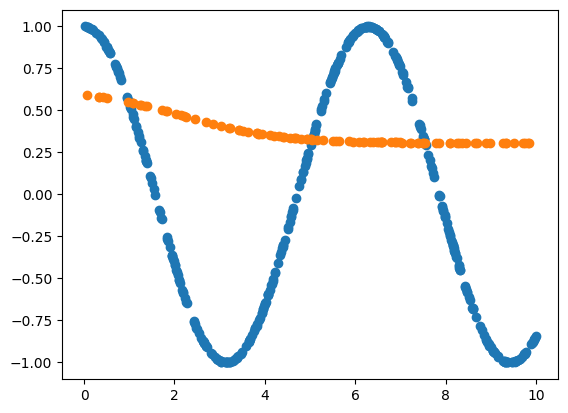

In [963]:
plt.plot(X_train, y_train, 'o')
plt.plot(X_val, preds, 'o')
plt.show()

# LinearRegression

In [2515]:
from sklearn.linear_model import LinearRegression

In [966]:
sklearn_X_train = np.array(X_train)
sklearn_X_train = sklearn_X_train.reshape(-1, 1)

sklearn_y_val = np.array(y_val)
sklearn_y_val = sklearn_y_val.reshape(-1, 1)

In [2832]:
sklearn_model = LinearRegression().fit(sklearn_X_train, y_train)

In [2833]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

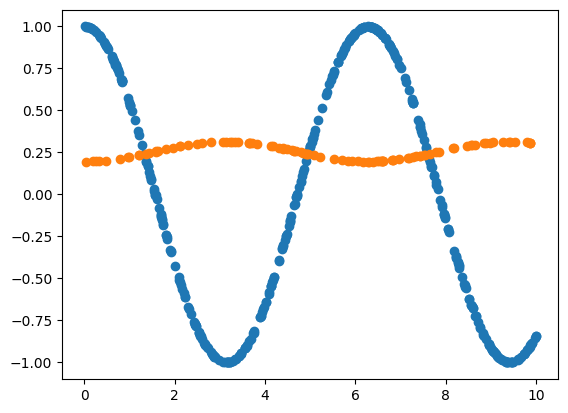

In [2834]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# MLPRegressor

In [967]:
from sklearn.neural_network import MLPRegressor

In [977]:
sklearn_model = MLPRegressor(random_state=0).fit(sklearn_X_train, y_train)

/Users/phil/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [978]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

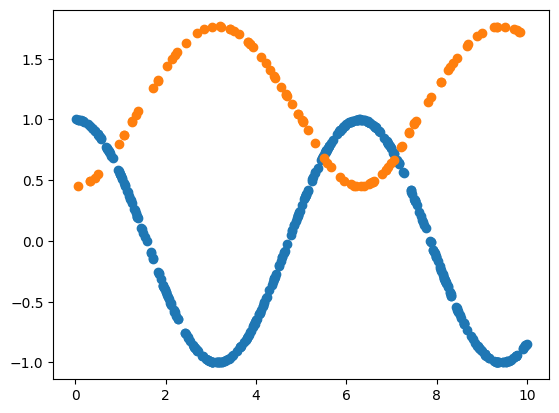

In [979]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()